The simulate_microservice function models how memory usage and latency respond to varying cache sizes and traffic levels. As cache size increases, memory usage naturally grows, while latency initially decreases (due to fewer database hits) but begins to rise again once cache exceeds a threshold (ideal_cache = 150), simulating garbage collection pressure. To evaluate performance, the score function combines memory and latency into a single metric, favoring lower values of both. The evaluate_config function runs multiple simulations per configuration to get a statistically stable average score. Using this evaluation, the hill_climb function performs optimization over a range of traffic levels by adjusting cache size step-by-step, selecting the configuration that yields the highest score. Finally, a plot of Optimal Cache Size vs. Traffic Level is generated, showing how the system adapts in response to different loads, and the optimal values are printed for inspection. This provides a simplified but insightful look into real-time tuning strategies used in microservice platforms like Netflix and Azure.


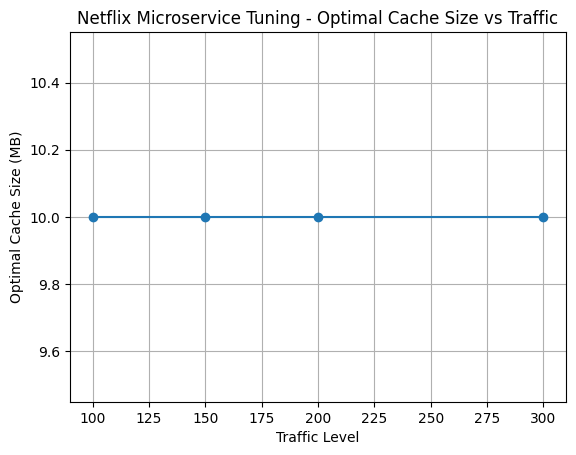

Traffic: 100 → Optimal Cache Size: 10 MB | Score: -86.25
Traffic: 150 → Optimal Cache Size: 10 MB | Score: -93.11
Traffic: 200 → Optimal Cache Size: 10 MB | Score: -100.06
Traffic: 300 → Optimal Cache Size: 10 MB | Score: -114.20


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated Netflix Microservice Environment

def simulate_microservice(cache_size, traffic_level):
    """
    Simulate the memory and latency of a microservice:
    - cache_size: memory allocated for caching
    - traffic_level: simulated request volume
    """
    # Memory usage increases with cache size and traffic
    base_mem = 50 + 0.4 * cache_size + 0.2 * traffic_level
    memory_noise = np.random.normal(0, 3)
    memory_usage = base_mem + memory_noise

    # Latency improves with moderate cache (less DB hits) but gets worse if too much memory is allocated (GC pressure)
    ideal_cache = 150
    latency = 100 - 0.2 * min(cache_size, ideal_cache) + 0.05 * traffic_level + 0.02 * max(cache_size - ideal_cache, 0)
    latency_noise = np.random.normal(0, 2)
    latency += latency_noise

    return memory_usage, latency

# Performance metric (lower is better)
def score(memory, latency):
    return -0.6 * memory - 0.4 * latency

# Statistical evaluation
def evaluate_config(cache_size, traffic_level, trials=8):
    scores = []
    for _ in range(trials):
        mem, lat = simulate_microservice(cache_size, traffic_level)
        scores.append(score(mem, lat))
    return np.mean(scores), np.std(scores)

# Hill Climbing Tuner
def hill_climb(initial_cache=100, step=10, traffic_profile=[100, 150, 200, 300], max_iter=10):
    config = initial_cache
    history = []

    for traffic in traffic_profile:
        best_score, _ = evaluate_config(config, traffic)
        improved = True
        iterations = 0

        while improved and iterations < max_iter:
            neighbors = [config + step, config - step]
            neighbors = [n for n in neighbors if n > 0]
            improved = False
            for neighbor in neighbors:
                candidate_score, _ = evaluate_config(neighbor, traffic)
                if candidate_score > best_score:
                    config = neighbor
                    best_score = candidate_score
                    improved = True
                    break
            iterations += 1
        history.append((traffic, config, best_score))

    return history

# Run it
tuning_results = hill_climb()

# Plot Results
traffic, configs, scores = zip(*tuning_results)
plt.plot(traffic, configs, marker='o')
plt.title("Netflix Microservice Tuning - Optimal Cache Size vs Traffic")
plt.xlabel("Traffic Level")
plt.ylabel("Optimal Cache Size (MB)")
plt.grid(True)
plt.show()

for t, c, s in tuning_results:
    print(f"Traffic: {t} → Optimal Cache Size: {c} MB | Score: {s:.2f}")


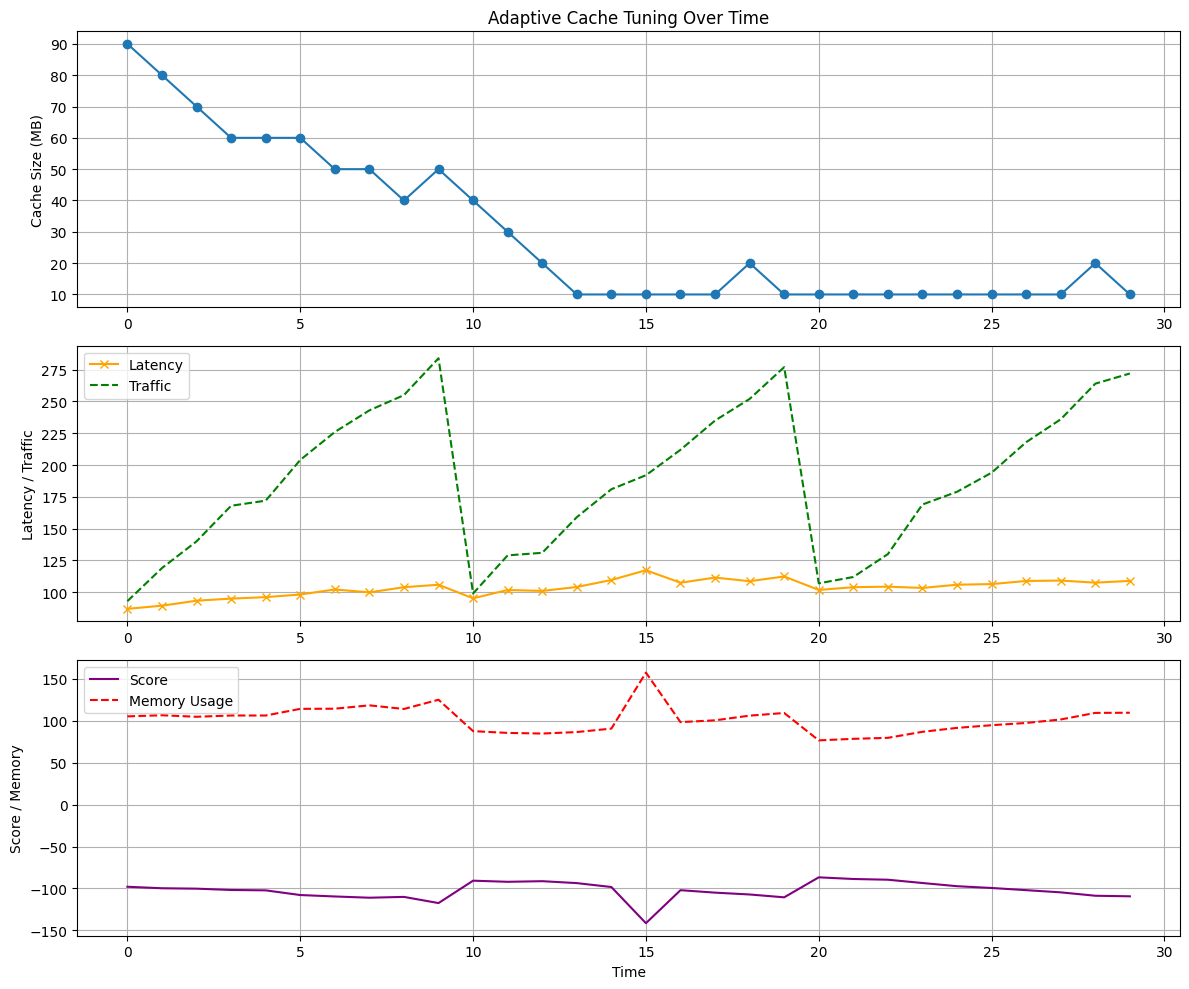

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated Netflix Microservice Environment
def simulate_microservice(cache_size, traffic_level, anomaly=False):
    if anomaly:
        traffic_level *= 2
        memory_leak = 30
    else:
        memory_leak = 0

    base_mem = 50 + 0.4 * cache_size + 0.2 * traffic_level + memory_leak
    memory_usage = base_mem + np.random.normal(0, 4)

    ideal_cache = 150
    latency = 100 - 0.2 * min(cache_size, ideal_cache) + 0.05 * traffic_level + 0.02 * max(cache_size - ideal_cache, 0)
    latency += np.random.normal(0, 3)

    return memory_usage, latency

def compute_score(memory, latency):
    return -0.6 * memory - 0.4 * latency

def evaluate_config(cache_size, traffic_level, anomaly=False, trials=6):
    scores, mems, lats = [], [], []
    for _ in range(trials):
        mem, lat = simulate_microservice(cache_size, traffic_level, anomaly)
        mems.append(mem)
        lats.append(lat)
        scores.append(compute_score(mem, lat))
    return np.mean(scores), np.mean(mems), np.mean(lats)

def hill_climb_adaptive(time_steps=30, initial_cache=100, step=10):
    cache_size = initial_cache
    history = {
        "time": [], "traffic": [], "cache_size": [],
        "latency": [], "memory": [], "score": [], "anomaly": []
    }

    for t in range(time_steps):
        traffic = 100 + 20 * (t % 10) + np.random.randint(-10, 10)
        anomaly = True if t == 15 else False

        best_score, best_mem, best_lat = evaluate_config(cache_size, traffic, anomaly)

        neighbors = [cache_size + step, cache_size - step]
        neighbors = [n for n in neighbors if n > 0]

        for n in neighbors:
            score, mem, lat = evaluate_config(n, traffic, anomaly)
            if score > best_score:
                cache_size, best_score, best_mem, best_lat = n, score, mem, lat
                break

        history["time"].append(t)
        history["traffic"].append(traffic)
        history["cache_size"].append(cache_size)
        history["latency"].append(best_lat)
        history["memory"].append(best_mem)
        history["score"].append(best_score)
        history["anomaly"].append(anomaly)

    return history

# Run it
results = hill_climb_adaptive()

# Plot multiple metrics
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(results["time"], results["cache_size"], label='Cache Size', marker='o')
plt.title("Adaptive Cache Tuning Over Time")
plt.ylabel("Cache Size (MB)")
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(results["time"], results["latency"], label='Latency', color='orange', marker='x')
plt.plot(results["time"], results["traffic"], label='Traffic', color='green', linestyle='--')
plt.ylabel("Latency / Traffic")
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(results["time"], results["score"], label='Score', color='purple')
plt.plot(results["time"], results["memory"], label='Memory Usage', color='red', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Score / Memory")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Parameters
TIME_STEPS = 50
cache_size = 100
step = 10
history = {
    "time": [], "traffic": [], "cache_size": [],
    "latency": [], "memory": [], "score": [],
    "anomaly": [], "cost": []
}

# Simulation function
def simulate_microservice(cache_size, traffic_level, anomaly=False):
    if anomaly:
        traffic_level *= 2
        memory_leak = 30
    else:
        memory_leak = 0

    cache_hit_ratio = min(1.0, cache_size / (0.6 * traffic_level + 1))
    base_latency = 180
    fallback_latency = 300
    latency = base_latency * (1 - cache_hit_ratio) + fallback_latency * cache_hit_ratio
    latency += np.random.normal(0, 5)

    memory_usage = 50 + 0.5 * cache_size + 0.1 * traffic_level + memory_leak
    if memory_usage > 400:
        latency += 50

    # Cost model
    mem_cost = 0.0005 * memory_usage
    latency_cost = 0.001 * max(0, latency - 200)
    total_cost = mem_cost + latency_cost

    # Alerts
    alerts = []
    if memory_usage > 420:
        alerts.append("High memory usage")
    if latency > 250:
        alerts.append("High latency")

    return memory_usage, latency, total_cost, alerts

# Scoring function
def compute_score(memory, latency):
    return -0.6 * memory - 0.4 * latency

# Evaluate with multiple trials
def evaluate_config(cache_size, traffic_level, anomaly=False, trials=6):
    scores, mems, lats, costs = [], [], [], []
    for _ in range(trials):
        mem, lat, cost, _ = simulate_microservice(cache_size, traffic_level, anomaly)
        mems.append(mem)
        lats.append(lat)
        scores.append(compute_score(mem, lat))
        costs.append(cost)
    return np.mean(scores), np.mean(mems), np.mean(lats), np.mean(costs)

# Plot setup
fig, axs = plt.subplots(4, 1, figsize=(10, 12))
lines = [
    axs[0].plot([], [], label='Cache Size', color='blue')[0],
    axs[1].plot([], [], label='Latency', color='orange')[0],
    axs[1].plot([], [], label='Traffic', color='green')[0],
    axs[2].plot([], [], label='Score', color='purple')[0],
    axs[3].plot([], [], label='Cost', color='red')[0]
]

axs[0].set_ylabel("Cache Size")
axs[1].set_ylabel("Latency / Traffic")
axs[2].set_ylabel("Score")
axs[3].set_ylabel("Cost ($)")
axs[3].set_xlabel("Time Step")

for ax in axs:
    ax.legend()
    ax.grid(True)

# Animation update logic
def update(frame):
    global cache_size

    t = frame
    traffic = 100 + 80 * np.sin(2 * np.pi * t / 24) + np.random.normal(0, 10)
    anomaly = t in [15, 32]

    # Main config
    best_score, best_mem, best_lat, best_cost = evaluate_config(cache_size, traffic, anomaly)

    # Hill climbing step
    for neighbor in [cache_size + step, cache_size - step]:
        if neighbor <= 0:
            continue
        score, mem, lat, cost = evaluate_config(neighbor, traffic, anomaly)
        if score > best_score:
            cache_size = neighbor
            best_score, best_mem, best_lat, best_cost = score, mem, lat, cost
            break

    # Log data
    history["time"].append(t)
    history["traffic"].append(traffic)
    history["cache_size"].append(cache_size)
    history["latency"].append(best_lat)
    history["memory"].append(best_mem)
    history["score"].append(best_score)
    history["cost"].append(best_cost)
    history["anomaly"].append(anomaly)

    # Update plots
    lines[0].set_data(history["time"], history["cache_size"])
    lines[1].set_data(history["time"], history["latency"])
    lines[2].set_data(history["time"], history["traffic"])
    lines[3].set_data(history["time"], history["score"])
    lines[4].set_data(history["time"], history["cost"])

    for ax in axs:
        ax.relim()
        ax.autoscale_view()

    return lines

# Create animation
ani = FuncAnimation(fig, update, frames=TIME_STEPS, interval=500, repeat=False)
plt.close(fig)  # Prevent duplicate image in notebooks

# Render in HTML
HTML(ani.to_jshtml())
